In [1]:
import sys

class UnbufferedStream:
    def __init__(self, stream):
        self._stream = stream
    def write(self, data):
        self._stream.write(data)
        self._stream.flush()
    def writelines(self, lines):
        self._stream.writelines(lines)
        self._stream.flush()
    def __getattr__(self, name):
        return getattr(self._stream, name)

sys.stdout = UnbufferedStream(sys.stdout)
sys.stderr = UnbufferedStream(sys.stderr)

In [2]:
from smooth import is_smooth, sieve_to, psi_approx, log_dickman, factorize, is_prime, bench_solve
from random import randint, seed, random, Random
from bisect import bisect_left, bisect_right
from collections import namedtuple
import matplotlib.pyplot as plt
import gmpy2
import math
import time
import os

In [ ]:
'''
Benchmark p=9223372036854775783 | C=1
Factorized order to [(2, 1), (3, 4), (17, 1), (23, 1), (319279, 1), (456065899, 1)]
Found generator g=4579067704563355938
Using heuristics: y=8784, expectation=1668, k=1095
Built factor base tree
Using S=3
'''

'\nBenchmark p=72057594037927847 | C=1, S=1\nFactorized order to [(2, 1), (79, 1), (163, 1), (2797918538399, 1)]\nFound generator g=1147215849234026\nUsing heuristics: y=4567, expectation=967, k=619\n'

In [64]:
(1 << 75) - 97

37778931862957161709471

In [28]:
def rank_prob(S, factor_base, p):
    k = len(factor_base)
    if k == 0:
        return 0.0

    ln_p  = math.log(p)
    lnlnp = math.log(ln_p)
    w     = math.ceil(math.sqrt(ln_p / lnlnp))

    p_hit      = w / k
    n_rows     = S * k
    miss_prob  = (1.0 - p_hit) ** n_rows
    exp_miss   = k * miss_prob
    return math.exp(-exp_miss)

In [37]:
p = 2 ** 64
y = estim_y(p)
factorBase = sieve_to(y)

In [39]:
rank_prob(3.0, factorBase, p)

0.9928786039068072

In [65]:
factorize((1 << 75) - 97 - 1)

[(2, 1),
 (3, 2),
 (5, 1),
 (11, 1),
 (23, 1),
 (157, 1),
 (4229021, 1),
 (2498890063, 1)]

In [3]:
import numpy as np
import re

def parse_sparse_matrix(path: str, k: int, q) -> np.ndarray:
    pattern = re.compile(r"\((\d+)\s*,\s*(\d+)\)")   # matches "(col, exp)"
    rows = []

    with open(path, "r", encoding="utf8") as fh:
        for line in fh:
            if ":" not in line:
                continue
            row = np.zeros(k, dtype=int)
            for col, exp in pattern.findall(line):
                col_i = int(col)
                row[col_i] = (row[col_i] + int(exp)) % q
            rows.append(row)

    return np.stack(rows, axis=0)


def parse_vector_str(xs: str, return_numpy: bool = True):
    try:
        payload = xs[xs.index('[') + 1 : xs.rindex(']')]
    except ValueError:
        raise ValueError("Missing '[' or ']' in input string")

    tokens = [tok for tok in re.split(r'[,\s]+', payload) if tok]
    values = [int(tok) for tok in tokens]
    return np.asarray(values, dtype=object) if return_numpy else values

def parse_int_sequence(seq: str, return_numpy: bool = True):
    payload = re.sub(r'^[^-\d]*', '', seq, count=1)        # keep the first digit
    tokens  = [tok for tok in re.split(r'[,\s]+', payload) if tok]
    values  = [int(tok) for tok in tokens]
    return np.asarray(values, dtype=object) if return_numpy else values

def verify_relation(M: np.ndarray,
                    L: np.ndarray,
                    X: np.ndarray,
                    q: int,
                    *,
                    verbose: bool = False) -> bool:
    L  = L.reshape(-1, 1)
    Xr = (X % q).reshape(-1, 1)          # reduce RHS only

    residual = (M.dot(L) - Xr) % q

    ok = np.all(residual == 0)

    if verbose and not ok:
        bad = np.where(residual.ravel() != 0)[0]
        print(f"Failed on {bad.size} out of {M.shape[0]} rows:", bad)

    return bool(ok)

In [9]:
# M2 = parse_sparse_matrix("temp.txt", 70, 2)
M = parse_sparse_matrix("temp.txt", 2780, 2)
# M19 = parse_sparse_matrix("temp.txt", 70, 19)
# M22605091 = parse_sparse_matrix("temp.txt", 70, 22605091)
np.linalg.matrix_rank(M)
# np.linalg.matrix_rank(M5), np.linalg.matrix_rank(M19), np.linalg.matrix_rank(M22605091)

np.int64(2780)

In [56]:
Lstring = "L = 16644435 19671880 12704827 5216328 8794037 14662921 4480887 19529779 14306035 718368 10462964 10131443 16344656 2289680 7973105 16634960 3632492 18021353 12053528 13879852 20317492 4876282 20298856 7044423 15315869 12214441 5414415 5910499 21533489 17292424 2564573 10394996 6341269 16152256 9335851 6343558 16579911 2505673 11944779 12750175 13514638 3520094 6220951 5563388 6117997 10920285 11104130 6334385 17690411 21064159 19433086 2978575 21797523 5310816 15281027 18092806 18946284 12060549 8077154 12397557 18429610 10657103 12250525 8932010 5209814 8698989 9575938 19183794 17801893 9755365"
Xstring = "X= [1357061518, 760418525, 1749604139, 621426109, 693777844, 3547735180, 1230532452, 1027939165, 2106345364, 1352835184, 3768325887, 950709481, 948662673, 3144302533, 2626729284, 3185788814, 2440181776, 2138495464, 2394671386, 847640607, 3870042868, 1468672720, 1034241204, 3268553623, 3792867097, 1540925693, 1850807056, 373169191, 1088849083, 1390908702, 891383136, 4039669047, 3877753151, 3199595097, 1581267418, 3036810975, 3377339831, 1855716999, 235554607, 876327258, 2321823217, 2609466639, 3431615000, 939834646, 2765511721, 3279347220, 3001103064, 2608717435, 4209607894, 3503891005, 4288533811, 1145107079, 2442570283, 397522318, 2971319466, 3646380894, 1827593801, 4180315409, 1314211833, 24513693, 1970973492, 631162428, 749387114, 2766830820, 2363065064, 535121082, 2220450839, 2971520463, 2801966967, 3814672540, 509997876, 1967736761, 1919691585, 3354215551, 1685451195, 3330809763, 1188891802, 32326227, 3950871061, 1096928928, 562833042, 2702476304, 3922023991, 2687715451, 1405203977, 1685066386, 1468194051, 2572532500, 3834510874, 167310645, 546813414, 1266637319, 1088281575, 2900967052, 3076559434, 32166918, 1561829858, 1917677961, 585642333, 1685586758, 2036485413, 1552695683, 4282820850, 95366390, 2428928060, 138108703, 2981219013, 283000909, 2345656235, 958211107, 2161740216, 869391089, 829121511, 1127118114, 704449200, 619058537, 4146740174, 2969439738, 750058800, 3763366018, 971930451, 3406629602, 2046945975, 3494505926, 1405497088, 608735451, 1906961309, 1301372872, 2362265614, 1313750546, 609766377, 2010892440, 4018176397, 24090774, 3973810563, 725585284, 4044241922, 1589249664, 225769047, 3095966976]"

L = parse_int_sequence(Lstring)
X = parse_vector_str(Xstring)
M.shape, len(L), len(X)

((140, 70), 70, 140)

In [57]:
verify_relation(M, L, X, 22605091)

True

In [11]:
PRIMES = tuple(sieve_to(1 << 22))

In [30]:
P = 2**46
u = math.log(P) / math.log(y)
math.exp(log_dickman(u))



0.0017035800009750997

In [8]:
def estim_y(p):
    L = math.log(p)
    return int(math.exp(math.sqrt(0.5 * L * math.log(L))))

def WORK(b):
    P = 2 ** b
    y = estim_y(P)
    u = math.log(P) / math.log(y)
    rarity = 1 / math.exp(log_dickman(u))
    k = y / math.log(y)
    return 4 * k * rarity

In [12]:
y = estim_y(37778931862957161709471)

In [13]:
len(sieve_to(y))

2780

In [71]:
WORK(75) / WORK(63)

6.2321178875977115

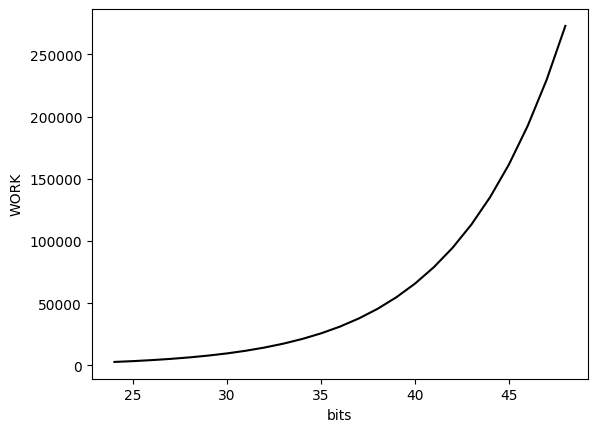

In [43]:
x = range(24, 49); y = [WORK(n) for n in x]
fig, ax = plt.subplots()
ax.plot(x, y, 'k-')
ax.set_xlabel('bits'); ax.set_ylabel('WORK')
ax.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.show()

In [14]:
P = 37778931862957161709471

In [15]:
def find_gen(p):
    primes = [q for (q, _) in factorize(p-1)]

    while True:
        g = randint(2, p - 1)
        valid = True
        for q in primes:
            if pow(g, (p - 1) // q, p) == 1:
                valid = False
                break
        if valid:
            return g

g = find_gen(P)
g

21432078812718990714575

In [16]:
def build_product_tree(values, k):
    levels = []
    level = [gmpy2.mpz(p) for p in values[:k]]
    levels.append(level)
    while len(level) > 1:
        next_level = []
        for i in range(0, len(level), 2):
            if i + 1 < len(level):
                next_level.append(level[i] * level[i+1])
            else:
                next_level.append(level[i])
        levels.append(next_level)
        level = next_level
    return levels

def batch_remainder(p_levels, X):
    Z = p_levels[-1][0]

    x_levels = build_product_tree(X, len(X))
    h = len(x_levels) - 1

    root_prod = x_levels[h][0]
    rems = [gmpy2.t_mod(Z, root_prod)]

    for level in range(h, 0, -1):
        parent_rems = rems
        node_products = x_levels[level - 1]
        size = len(node_products)
        rems = [None] * size
        for idx in range(size):
            rems[idx] = gmpy2.t_mod(parent_rems[idx // 2], node_products[idx])
    return rems

def batch_smoothness_test(p_levels, X):
    rems = batch_remainder(p_levels, X)
    
    max_x = max(X)
    M = 1 << (max_x.bit_length())
    
    smooth_cands = set()
    for x_mpz, r in zip(X, rems):
        y = gmpy2.powmod(r, M, x_mpz)
        if gmpy2.gcd(x_mpz, y) == x_mpz:
            smooth_cands.add(x_mpz)
    
    return smooth_cands

In [19]:
levels = build_product_tree(PRIMES, 2780)

In [37]:
total = 0

for _ in range(1100):
    X_hat = [gmpy2.mpz(randint(0, P-2)) for _ in range(4048)]
    X = [pow(g, hat, P) for hat in X_hat]
    t1 = time.time()
    x = batch_smoothness_test(levels, X)
    t2 = time.time()
    total += len(x)
    print((t2 - t1) )

0.013670921325683594
0.012914896011352539
0.01029515266418457
0.009412050247192383
0.00984811782836914
0.009141206741333008
0.009361028671264648
0.009729623794555664
0.009376049041748047
0.009357213973999023
0.009369134902954102
0.009343147277832031
0.00910806655883789
0.009460210800170898
0.009301900863647461
0.009466886520385742
0.00917816162109375
0.009425163269042969
0.009348154067993164
0.0092620849609375
0.00933384895324707
0.009715080261230469
0.009338140487670898
0.009885787963867188
0.009518623352050781
0.009364128112792969
0.009546995162963867
0.009313106536865234
0.009519100189208984
0.00959467887878418
0.009170293807983398
0.009272098541259766
0.009282112121582031
0.009698867797851562
0.009576797485351562
0.00927591323852539
0.00920867919921875
0.009624958038330078
0.01031494140625
0.01190185546875
0.01342320442199707
0.009458780288696289
0.00990605354309082
0.009518861770629883
0.009567975997924805
0.009703874588012695
0.009476900100708008
0.009300947189331055
0.0093126296

In [34]:
total

1285

In [27]:
3.6392994077780503e-06 * 4048

0.014731884002685547

In [16]:
X = [gmpy2.mpz(randint(0, P-2)) for _ in range(131072)]
t1 = time.time()
x = batch_smoothness_test(levels, X)
print(time.time() - t1)

0.8504021167755127


In [112]:
factorize(2**64 - 59 - 1)

[(2, 2), (11, 1), (137, 1), (547, 1), (5594472617641, 1)]

In [46]:
arr = list(x)
arr[0].bit_length()

127

In [48]:
t1 = time.time()
print(extract_prime_power_factors(levels, arr[0]))
print(time.time() - t1)

[(686143, 1), (389083, 1), (213391, 1), (67607, 1), (19081, 1), (13997, 1), (2857, 1), (857, 1), (7, 1), (2, 3)]
0.0037851333618164062


In [21]:
def extract_prime_divisors(p_levels, d):
    primes = []
    h = len(p_levels) - 1
    stack = [(h, 0)]
    
    while stack:
        level, idx = stack.pop()
        P = p_levels[level][idx]
        g = gmpy2.gcd(d, P)
        if g == 1:
            continue
        if level == 0:
            primes.append(P)
        else:
            left_idx = 2 * idx
            right_idx = left_idx + 1
            stack.append((level - 1, left_idx))
            if right_idx < len(p_levels[level - 1]):
                stack.append((level - 1, right_idx))
    return primes

def extract_prime_power_factors(p_levels, d):
    factorization = []
    primes = extract_prime_divisors(p_levels, d)
    for p in primes:
        exp = 0
        while d % p == 0:
            d //= p
            exp += 1
        factorization.append((int(p), exp))
    return factorization